## 1. Data Import and Exploration

In this section, we import stock price data using the `yfinance` library. We will fetch historical price data for a selected company (e.g., AAPL – Apple Inc.) and explore its structure. This includes examining columns, checking for missing values, and understanding the temporal resolution of the data.


In [1]:
# Install yfinance if not already installed
#!pip install yfinance 

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:

"""
#update this to include more tickers
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
# Download historical stock data for multiple tickers
data = yf.download(tickers, start="2015-01-01", end="2024-12-31", interval="1d")

# Display the first few rows of the dataset
print(data.head())

"""
# Download historical stock data (Apple Inc. as example)
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")

# Display the first few rows of the dataset
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400
2015-01-05,23.635288,24.169168,23.448431,24.089086,257142000
2015-01-06,23.637516,23.897782,23.274922,23.699802,263188400
2015-01-07,23.968964,24.069065,23.735391,23.846616,160423600
2015-01-08,24.889900,24.947738,24.180285,24.298185,237458000


### Dataset Description

The dataset includes the following columns:

- **Open**: Opening price of the stock on the trading day
- **High**: Highest price during the day
- **Low**: Lowest price during the day
- **Close**: Closing price on the trading day
- **Adj Close**: Adjusted closing price (adjusted for splits/dividends)
- **Volume**: Number of shares traded

We use the datetime index to work with time-based operations later in the pipeline.


In [4]:
# Basic information about the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2515 non-null   float64
 1   (High, AAPL)    2515 non-null   float64
 2   (Low, AAPL)     2515 non-null   float64
 3   (Open, AAPL)    2515 non-null   float64
 4   (Volume, AAPL)  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


In [5]:
# Check for missing values
data.isnull().sum()


Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

### Notes

- Ensure there are no significant gaps or missing values in the dataset.
- We'll use the "Adj Close" column as the primary signal for forecasting.
- Further preprocessing will include normalization, sequence generation, and train-test split.


## 2. Preprocessing

In this section, we clean and prepare the stock data for modeling. We will:

- Handle missing values
- Visualize the time series
- Normalize the data
- Apply windowing to create supervised learning sequences
- Split the dataset into training and test sets


In [6]:
# Check the actual column names
print(data.columns)


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [7]:
# Flatten MultiIndex columns
data.columns = data.columns.get_level_values(0)

# Use 'Close' as the main signal
data = data[['Close']].copy()
data.rename(columns={'Close': 'price'}, inplace=True)

# Forward-fill missing data (e.g., for non-trading days)
data.ffill(inplace=True)


### 2.1 Visualize the Adjusted Closing Price

We plot the time series to inspect trends and seasonality before further transformation.


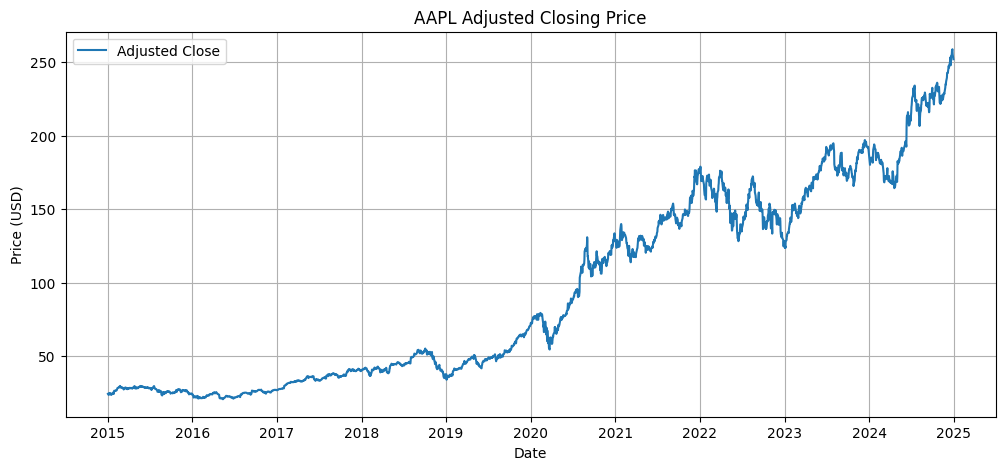

In [8]:

plt.figure(figsize=(12, 5))
plt.plot(data.index, data['price'], label='Adjusted Close')
plt.title(f"{ticker} Adjusted Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


### 2.2 Normalization

We normalize the data to the [0, 1] range using Min-Max scaling. This improves model convergence, especially for neural networks and hybrid quantum models.


In [ ]:
# normalize the data to the [0, 1] range using Min-Max scaling.
scaler = MinMaxScaler()
data['normalized'] = scaler.fit_transform(data[['price']])

### 2.3 Windowing the Data

To perform time series forecasting, we convert the normalized series into input/output sequences using a sliding window approach.

For example, with a window size of 10:
- Input: `t0` to `t9`
- Output: `t10`

We define a utility function to generate these sequences.


In [ ]:
# To perform time series forecasting, we convert the normalized series into input/output sequences using a sliding window approach.
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

# Use a window size (e.g., 20)
WINDOW_SIZE = 20
series = data['normalized'].values
X, y = create_sequences(series, WINDOW_SIZE)


### 2.4 Train-Test Split

We split the data into training and testing sets.
For example, we may use the last 20% of the sequences for testing.


In [ ]:
# split the data into training and testing sets.
# For example, we may use the last 20% of the sequences for testing.
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training sequences: {X_train.shape}")
print(f"Test sequences: {X_test.shape}")


Training sequences: (1996, 20)
Test sequences: (499, 20)


## 📚 References for Preprocessing Methodology

The preprocessing steps used in this notebook are based on widely adopted practices in time series forecasting and deep learning for sequential data. The following references and resources were used to inform the methodology:

1. **MinMax Normalization**
   - Brownlee, J. (2017). *How to Normalize and Standardize Time Series Data in Python*. Machine Learning Mastery.  
     [https://machinelearningmastery.com/normalize-standardize-time-series-data-python/](https://machinelearningmastery.com/normalize-standardize-time-series-data-python/)

2. **Sliding Window for Supervised Learning**
   - Brownlee, J. (2018). *How to Prepare Time Series Data for Machine Learning*. Machine Learning Mastery.  
     [https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

3. **Train-Test Split Strategy**
   - Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: Principles and Practice (2nd ed.)*. Chapter 2.7 – Time series cross-validation.  
     [https://otexts.com/fpp2/](https://otexts.com/fpp2/)

4. **Stock Price Datasets**
   - Yahoo Finance via `yfinance` Python library  
     [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/)

5. **General Time Series Forecasting Practices**
   - Chollet, F. (2021). *Deep Learning with Python* (2nd ed.). Manning Publications. Chapter on time series prediction with LSTMs.

---

These references cover normalization techniques, sequence preparation, and how to structure time series problems for deep learning models.
